In [1]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [2]:
import pandas as pd
import numpy as np
import utils as uti

### Import data from WA

In [3]:
# Path to the uploaded CSV file and upload it
from preprocessWA import remove_extra_rows_WA
df_filtered_wa, conduct_cols  = remove_extra_rows_WA()
df_filtered_wa

Percentage of samples kept: 69.48%


,Description,rule1,rule2,rule3,rule4,rule5,rule6,rule7,rule8,rule9,rule10,rule11,rule12,rule13,rule14,rule15
0,"John A. Walsh (WSBA No. 20603, admitted 1991),...",3.4,8.4d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"Louis A. Ferreira (WSBA No. 20646, admitted 19...",1.2,1.8,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,"Roland O. Foster Balloun (WSBA No. 20884, admi...",1.1,1.14,1.15,1.8,1.8,3.3,3.4,4.4,8.4c,8.4d,8.4l,NaN,NaN,NaN,NaN
20,"Thomas G. Batson (WSBA No. 20888, admitted 199...",1.14,8.4c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,"Kevin G. Healy (WSBA No. 16307, admitted 1986)...",1.8,1.8,8.4c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,"Brad A. Plumb (WSBA No. 20337, admitted 1991),...",3.3,8.4b,8.4c,8.4i,8.4k,8.4n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1239,"Clinton L. Morgan (WSBA No. 22181, admitted 19...",1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1240,"Stephen B. Blanchard (WSBA No. 12294, admitted...",1.1,1.14,1.2,1.3,1.4,1.5,3.2,8.4c,8.4l,NaN,NaN,NaN,NaN,NaN,NaN
1241,"Mark Stansfield (WSBA No. 11356, admitted 1980...",1.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Find all unique labels (conduct)

In [4]:
#Get all the unique labels (conduct violations)
unique_conducts_wa = np.sort(pd.Series(df_filtered_wa[conduct_cols].values.ravel()).dropna().unique())
print((unique_conducts_wa), len(unique_conducts_wa))

['1.1' '1.10' '1.13' '1.14' '1.15' '1.15A' '1.15B' '1.2' '1.3' '1.4' '1.5'
 '1.6' '1.8' '1.9' '2.1' '3.1' '3.2' '3.3' '3.4' '3.5' '3.6' '3.8' '4.1'
 '4.2' '4.4' '5.1' '5.3' '5.4' '5.5' '5.8' '7.1' '7.2' '7.3' '7.5' '8.1'
 '8.2' '8.4' '8.4a' '8.4b' '8.4c' '8.4d' '8.4e' '8.4h' '8.4i' '8.4j'
 '8.4k' '8.4l' '8.4m' '8.4n'] 49


### Import data from NJ

In [5]:
from preprocessNJ import remove_extra_rows_NJ, extract_labels_rpc_NJ
desc_filtered_nj = remove_extra_rows_NJ()
desc_filtered_nj

Percentage of samples kept: 11.99%


,misconduct
0,"Censured on a certified record on July 20, 201..."
1,Disbarred on a certified record on September 1...
2,"Reprimanded on June 2, 2017, for violating RPC..."
3,"Reprimanded on December 1, 2017 (231 N.J. 165)..."
4,"Reprimanded on November 27, 2017 (231 N.J. 167..."
...,...
3267,Admitted: 1960; Atlantic City (Atlantic County...
3515,Admitted: 1978; Elizabeth (Union County) Suspe...
3532,Admitted: 1970; Totowa (Passaic County) Public...
3563,Admitted: 1971; Fort Lee (Bergen County) Suspe...


In [6]:
labels_nj = desc_filtered_nj['misconduct'].apply(extract_labels_rpc_NJ)
labels_nj = pd.DataFrame(labels_nj.to_list(), columns = df_filtered_wa.columns[1:])
labels_nj 

,rule1,rule2,rule3,rule4,rule5,rule6,rule7,rule8,rule9,rule10,rule11,rule12,rule13,rule14,rule15
0,1.15,8.1,None,None,None,None,None,None,None,None,None,None,None,None,None
1,1.15,1.15,1.15,5.5,8.1,8.1,8.4,None,None,None,None,None,None,None,None
2,1.7,1.8,None,None,None,None,None,None,None,None,None,None,None,None,None
3,1.3,3.2,3.5,3.4,8.4,None,None,None,None,None,None,None,None,None,None
4,1.8,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,1.5,None,None,None,None,None,None,None,None,None,None,None,None,None,None
464,1.5,None,None,None,None,None,None,None,None,None,None,None,None,None,None
465,1.7,None,None,None,None,None,None,None,None,None,None,None,None,None,None
466,1.15,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [7]:
df_filtered_nj = pd.concat([desc_filtered_nj.reset_index(drop=True), labels_nj.reset_index(drop=True)], axis=1)
df_filtered_nj

,misconduct,rule1,rule2,rule3,rule4,rule5,rule6,rule7,rule8,rule9,rule10,rule11,rule12,rule13,rule14,rule15
0,"Censured on a certified record on July 20, 201...",1.15,8.1,None,None,None,None,None,None,None,None,None,None,None,None,None
1,Disbarred on a certified record on September 1...,1.15,1.15,1.15,5.5,8.1,8.1,8.4,None,None,None,None,None,None,None,None
2,"Reprimanded on June 2, 2017, for violating RPC...",1.7,1.8,None,None,None,None,None,None,None,None,None,None,None,None,None
3,"Reprimanded on December 1, 2017 (231 N.J. 165)...",1.3,3.2,3.5,3.4,8.4,None,None,None,None,None,None,None,None,None,None
4,"Reprimanded on November 27, 2017 (231 N.J. 167...",1.8,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,Admitted: 1960; Atlantic City (Atlantic County...,1.5,None,None,None,None,None,None,None,None,None,None,None,None,None,None
464,Admitted: 1978; Elizabeth (Union County) Suspe...,1.5,None,None,None,None,None,None,None,None,None,None,None,None,None,None
465,Admitted: 1970; Totowa (Passaic County) Public...,1.7,None,None,None,None,None,None,None,None,None,None,None,None,None,None
466,Admitted: 1971; Fort Lee (Bergen County) Suspe...,1.15,None,None,None,None,None,None,None,None,None,None,None,None,None,None


### Combine the data from the states into one DataFrame

In [8]:
df_all_states = pd.concat([df_filtered_wa.reset_index(drop=True), df_filtered_nj.rename(columns={"misconduct": "Description"})], axis=0, ignore_index=True)
df_all_states

,Description,rule1,rule2,rule3,rule4,rule5,rule6,rule7,rule8,rule9,rule10,rule11,rule12,rule13,rule14,rule15
0,"John A. Walsh (WSBA No. 20603, admitted 1991),...",3.4,8.4d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Louis A. Ferreira (WSBA No. 20646, admitted 19...",1.2,1.8,1.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Roland O. Foster Balloun (WSBA No. 20884, admi...",1.1,1.14,1.15,1.8,1.8,3.3,3.4,4.4,8.4c,8.4d,8.4l,NaN,NaN,NaN,NaN
3,"Thomas G. Batson (WSBA No. 20888, admitted 199...",1.14,8.4c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Kevin G. Healy (WSBA No. 16307, admitted 1986)...",1.8,1.8,8.4c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,Admitted: 1960; Atlantic City (Atlantic County...,1.5,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1336,Admitted: 1978; Elizabeth (Union County) Suspe...,1.5,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1337,Admitted: 1970; Totowa (Passaic County) Public...,1.7,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1338,Admitted: 1971; Fort Lee (Bergen County) Suspe...,1.15,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [9]:
unique_conducts = np.sort(pd.Series(df_all_states[conduct_cols].values.ravel()).dropna().unique())
print((unique_conducts), len(unique_conducts))

['' '.' '1.1' '1.10' '1.13' '1.14' '1.15' '1.15A' '1.15B' '1.16' '1.17'
 '1.2' '1.3' '1.3.' '1.4' '1.5' '1.5.' '1.6' '1.7' '1.8' '1.9' '2.1' '3.1'
 '3.2' '3.3' '3.4' '3.5' '3.6' '3.8' '4.1' '4.2' '4.2.' '4.4' '5.1' '5.3'
 '5.4' '5.5' '5.6' '5.8' '6.2' '7.1' '7.2' '7.3' '7.4' '7.5' '8.1' '8.2'
 '8.4' '8.4a' '8.4b' '8.4c' '8.4d' '8.4e' '8.4h' '8.4i' '8.4j' '8.4k'
 '8.4l' '8.4m' '8.4n' '8.5'] 61


### Group the labels into 10 bins

In [10]:
dict_unique_conducts = {"1.1":1, "1.3":1, 
        "1.15":2, "1.15A":2, "1.15B":2,
        "1.4":3,
        "1.7":4, "1.8":4, "1.10":4, "1.11":4, "1.16":4, "1.17":4,
        "1.2":5, "1.5":5, "1.5.":5, "1.6":5, '1.9':5, "1.12":5, '1.13':5, '1.14':5,
        "2.1":6, "2.2":6, "2.3":6, "2.4":6, "3.1":6, "3.2":6, "3.3":6, "3.4":6, "3.5":6, "3.6":6, "3.7":6, "3.8":6, "3.9":6,
        "4.1":7, "4.2":7, "4.2.":7, "4.3":7, "4.4":7, "5.1":7, "5.2":7, "5.3":7, "5.4":7, "5.5":7, "5.6":7, "5.7":7, "5.8":7, "6.1":7, "6.2":7, "6.3":7, "6.4":7, "6.5":7, "7.1":7, "7.2":7, "7.3":7, "7.4":7, "7.5":7,"7.6":7,
        "8.4b":8,
        "8.4c":9,
        '8.1':10, '8.2':10, '8.4':10, '8.4a':10, '8.4d':10, '8.4e':10, '8.4h':10, '8.4i':10, '8.4j':10, '8.4k':10, '8.4l':10, '8.4m':10, '8.4n':10, '8.5':10}

In [11]:
unique_bins = list(set(dict_unique_conducts.values()))
df_all_states = df_all_states.replace(dict_unique_conducts)
df_all_states

,Description,rule1,rule2,rule3,rule4,rule5,rule6,rule7,rule8,rule9,rule10,rule11,rule12,rule13,rule14,rule15
0,"John A. Walsh (WSBA No. 20603, admitted 1991),...",6,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Louis A. Ferreira (WSBA No. 20646, admitted 19...",5,4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Roland O. Foster Balloun (WSBA No. 20884, admi...",1,5,2.0,4.0,4.0,6.0,6.0,7.0,9.0,10.0,10.0,NaN,NaN,NaN,NaN
3,"Thomas G. Batson (WSBA No. 20888, admitted 199...",5,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Kevin G. Healy (WSBA No. 16307, admitted 1986)...",4,4,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1335,Admitted: 1960; Atlantic City (Atlantic County...,5,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1336,Admitted: 1978; Elizabeth (Union County) Suspe...,5,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1337,Admitted: 1970; Totowa (Passaic County) Public...,4,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1338,Admitted: 1971; Fort Lee (Bergen County) Suspe...,2,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
unique_conducts = pd.Series(df_all_states[conduct_cols].values.ravel()).dropna().unique()
print((unique_conducts), len(unique_conducts))

[6 10 5 4 1 2.0 7.0 9.0 3.0 8 '1.3.' '.' ''] 13


### Preprocess Descriptions

In [14]:
# Preprocess data by converting text to lowercase, removing non-word characters and numbers, 
# excluding the specific word 'wsba', exclude single characters, tokenizing, removing stopwords, and applying lemmatization or stemming if method = "stemming"
preprocessor = uti.TextPreprocessor(method='lemmatization')
preprocessed_descriptions = df_all_states['Description'].apply(preprocessor.preprocess)
preprocessed_descriptions

0       john walsh admit seattle order censure pursuan...
1       louis ferreira admit vancouver receive censure...
2       roland foster balloun admit disbar follow hear...
3       thomas batson admit seattle disbar order supre...
4       kevin healy admit seattle resign lieu disbarme...
                              ...                        
1335    admit atlantic city atlantic county admonition...
1336    admit elizabeth union county suspension year n...
1337    admit totowa passaic county public reprimand n...
1338    admit fort lee bergen county suspension month ...
1339    admit edison middlesex county public reprimand...
Name: Description, Length: 1340, dtype: object

### Classification using logistic regression

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [23]:
scores = []
freq_label = []

for label in unique_bins:
    mask = df_all_states[conduct_cols].isin([label])
    index_with_label = df_all_states[mask].dropna(how='all').index.values.tolist()
    index_without_label = np.setdiff1d(np.array(preprocessed_descriptions.index),np.array(index_with_label))
    frequency = len(index_with_label)/len(preprocessed_descriptions)
    freq_label.append(frequency)
    df_labels = pd.DataFrame(np.append(np.ones(len(index_with_label)), np.zeros(len(index_without_label))),index = np.append(index_with_label, index_without_label))
    
    # descriptions_with_label = preprocessed_descriptions.loc[index_with_label]
    # descriptions_without_label = preprocessed_descriptions.drop(index_with_label)

    # split into test and train (check that every class is presented)
    y_test= [len(index_with_label)]
    while np.sum(y_test) == len(index_with_label):
        x_train, x_test, y_train, y_test = train_test_split(preprocessed_descriptions.values,df_labels.values,test_size=0.2)

    # vectorize the train and test descriptions
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_train_vectors = tfidf_vectorizer.fit_transform(x_train)
    tfidf_test_vectors = tfidf_vectorizer.transform(x_test)

    # run logistic regression on train data
    logreg=LogisticRegression()
    logreg.fit(tfidf_train_vectors,np.ravel(y_train))

    # estimate the accuracy of the model
    scores.append(logreg.score(tfidf_test_vectors, y_test))

### Accuracy estimation of the model

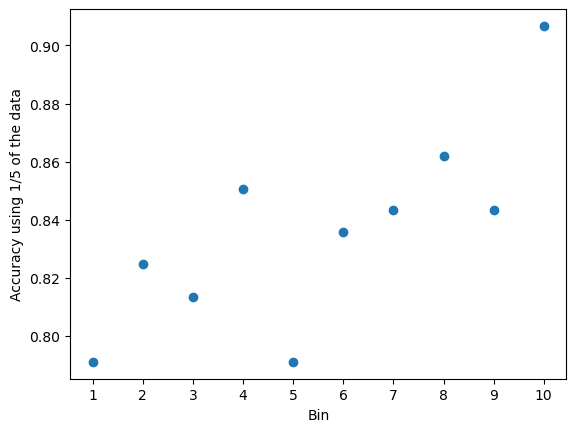

In [24]:
import matplotlib.pyplot as plt
plt.plot(unique_bins, scores,'o')
plt.ylabel("Accuracy using 1/5 of the data")
plt.xlabel("Bin")
plt.xticks(np.linspace(unique_bins[0],unique_bins[-1],len(unique_bins)))
plt.show()

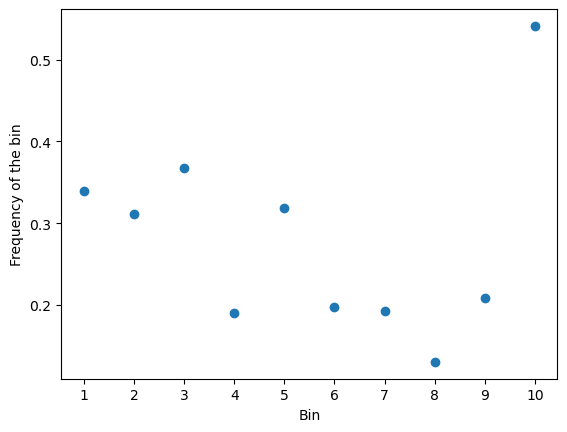

In [25]:
plt.scatter(unique_bins,freq_label)
plt.ylabel("Frequency of the bin")
plt.xlabel("Bin")
plt.xticks(np.linspace(unique_bins[0],unique_bins[-1],len(unique_bins)))
plt.show()

In [26]:
for i in range(len(unique_bins)):
    if freq_label[i] > 0.1:
        print(unique_bins[i], freq_label[i])

1 0.33955223880597013
2 0.3111940298507463
3 0.367910447761194
4 0.19029850746268656
5 0.31865671641791044
6 0.19776119402985073
7 0.19328358208955224
8 0.13059701492537312
9 0.208955223880597
10 0.5410447761194029
